In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import Dataset

from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers.utils import is_torch_bf16_gpu_available
from transformers import AutoModelForCausalLM

from jigsaw.settings import DATA_DIR, MODEL_DIR


train_path = DATA_DIR / "ds_spam_train.ds"
eval_path = DATA_DIR / "ds_spam_eval.ds"

train_dataset = Dataset.load_from_disk(str(train_path))
eval_dataset = Dataset.load_from_disk(str(eval_path))


/home/felix/repos/jigsaw/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/felix/repos/jigsaw/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an 

In [3]:
train_dataset[0]

{'prompt': [{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/Futurology </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>Banks don't want you to know this! Click here to know more!</comment>",
   'role': 'user'}],
 'completion': [{'content': 'no', 'role': 'assistant'}]}

In [4]:


def formatting(dataset):
    texts = []
    for i in range(len(dataset)):
        t = [dataset[i]['prompt'][0], dataset[i]['completion'][0]]
        texts.append(tokenizer.apply_chat_template(t, tokenize=False, add_generation_prompt=False))
    return Dataset.from_dict({'text': texts})


In [ ]:
from unsloth import FastLanguageModel
import torch
import os
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, LlamaForSequenceClassification
from trl import SFTConfig, SFTTrainer
import pandas as pd
import numpy as np

max_seq_length = 2048 
dtype = None          
load_in_4bit = True   

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-1.7B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = True,
    load_in_8bit = False,
    # full_finetuning = True,
    load_in_16bit = False,
)

/tmp/ipykernel_80337/2207906590.py:1: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 10-22 13:44:11 [__init__.py:235] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.7: Fast Qwen3 patching. Transformers: 4.57.1. vLLM: 0.10.0.
   \\   /|    NVIDIA GeForce RTX 4060 Laptop GPU. Num GPUs = 1. Max memory: 7.635 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [6]:
new_train_dataset = formatting(train_dataset)

In [7]:
new_train_dataset[0]

{'text': "<|im_start|>user\nYou are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/Futurology </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>Banks don't want you to know this! Click here to know more!</comment><|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nno<|im_end|>\n"}

In [8]:
from unsloth.chat_templates import train_on_responses_only
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

peft_model = FastLanguageModel.get_peft_model(
    model,
    r = 16, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0.1,    
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,  
    loftq_config = None, 
)

trainer = SFTTrainer(
    model = peft_model,
    tokenizer = tokenizer,
    train_dataset = new_train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 4,
    packing = False, 
    args = TrainingArguments(
        report_to = "none",
        num_train_epochs = 3,
        adam_epsilon=1e-6,
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 2, 
        optim = "paged_adamw_8bit",
        learning_rate = 1e-4,
        weight_decay = 0.01,
        max_grad_norm=1.0,
        lr_scheduler_type = "cosine",
        warmup_steps=40,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        dataloader_pin_memory=True,
        seed = 3407,
        output_dir = "outputs",
        # max_steps = 10,
    ),
)

trainer = train_on_responses_only(
    trainer,
    instruction_part="<|im_start|>user\n",
    response_part="<|im_start|>assistant\n",
)

trainer.train()

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.10.7 patched 36 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


NotImplementedError: Cannot copy out of meta tensor; no data!

In [ ]:
def formatting_eval(dataset):
    texts = []
    answers = []
    for i in range(len(dataset)):
        t = [dataset[i]['prompt'][0]]
        texts.append(tokenizer.apply_chat_template(t, tokenize=False, add_generation_prompt=True, enable_thinking=False))
        answers.append(1 if 'yes' in dataset[i]['completion'][0]["content"].lower() else 0)

    return {'text': texts, 'answer': answers}

new_eval_dataset = formatting_eval(eval_dataset)

In [ ]:
peft_model.save_pretrained(MODEL_DIR / "unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no")
tokenizer.save_pretrained(MODEL_DIR / "unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no")

('/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/tokenizer_config.json',
 '/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/special_tokens_map.json',
 '/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/chat_template.jinja',
 '/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/vocab.json',
 '/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/merges.txt',
 '/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/added_tokens.json',
 '/home/felix/repos/jigsaw/model/unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no/tokenizer.json')

In [ ]:
peft_model = FastLanguageModel.for_inference(peft_model)

In [ ]:
from transformers import TextStreamer
import torch.nn.functional as F

# Get token IDs for "yes" and "no"
yes_token_id = tokenizer.encode("yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("no", add_special_tokens=False)[0]

idx = 0
print(new_eval_dataset['answer'][idx])
output = peft_model.generate(
    **tokenizer([new_eval_dataset['text'][idx]], return_tensors = "pt", padding=True).to("cuda"),
    max_new_tokens = 1, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
    output_scores=True,  # Return scores (logits) for each generation step
    return_dict_in_generate=True,  # Return a dict with sequences and scores
)

# Immediately extract only yes/no logprobs and discard the rest to save memory
yes_no_logprobs = []
for scores in output.scores:
    # scores has shape [batch_size, vocab_size]
      # [batch_size, vocab_size]
    # Extract only yes and no columns
    yes_no = F.log_softmax(scores, dim=-1)
    yes_no = yes_no[:, [yes_token_id, no_token_id]]  # [batch_size, 2]
    print(yes_no)
    yes_no_logprobs.append(yes_no.cpu())  # Move to CPU to free GPU memory

# Clear the full scores from memory
# del output.scores
# import torch
# torch.cuda.empty_cache()

# Store filtered logprobs back
output.yes_no_logprobs = yes_no_logprobs  # List of [batch_size, 2] tensors


1
no
tensor([[-inf, 0.]], device='cuda:0')


In [ ]:
output.scores[0]

tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0')

In [ ]:


# print(f"Token IDs - yes: {yes_token_id}, no: {no_token_id}")

# # Now use the filtered logprobs (only yes/no)
# for token_idx, yes_no in enumerate(output.yes_no_logprobs):
#     # yes_no has shape [batch_size, 2] where column 0 is 'yes', column 1 is 'no'
#     yes_logprob = yes_no[0, 0].item()  # First batch item, yes token
#     no_logprob = yes_no[0, 1].item()   # First batch item, no token
    
#     print(f"\nToken {token_idx + 1}:")
#     print(f"  'yes' (id={yes_token_id}, logprob={yes_logprob:.4f})")
#     print(f"  'no' (id={no_token_id}, logprob={no_logprob:.4f})")

In [ ]:
import torch
import torch.nn.functional as F
import gc
from typing import List, Dict
from tqdm.auto import tqdm

def batch_inference_yes_no(
    texts: List[str],
    model,
    tokenizer,
    max_tokens_per_batch: int = 4096,
    max_new_tokens: int = 1,
    temperature: float = 0.6,
    top_p: float = 0.95,
    top_k: int = 20,
    device: str = "cuda"
):
    """
    Memory-efficient batched inference that returns yes/no logprobs for each text.
    
    Args:
        texts: List of input texts to process
        model: The language model
        tokenizer: The tokenizer
        max_tokens_per_batch: Maximum total tokens per batch (controls memory usage)
        max_new_tokens: Number of tokens to generate per sample
        temperature: Sampling temperature
        top_p: Nucleus sampling parameter
        top_k: Top-k sampling parameter
        device: Device to run on
        
    Returns:
        Dictionary mapping sample index to tensor of shape [max_new_tokens, 2]
        where [:, 0] is yes logprobs and [:, 1] is no logprobs
    """
    
    # Get token IDs for "yes" and "no"
    yes_token_id = tokenizer.encode("yes", add_special_tokens=False)[0]
    no_token_id = tokenizer.encode("no", add_special_tokens=False)[0]
    
    # Store results: index -> tensor of yes/no logprobs
    results = {}
    
    # Tokenize all texts first to get their lengths
    print("Tokenizing all texts...")
    tokenized_inputs = []
    for i, text in enumerate(tqdm(texts)):
        tokens = tokenizer(text, return_tensors="pt", add_special_tokens=True)
        token_count = tokens['input_ids'].shape[1]
        tokenized_inputs.append({
            'index': i,
            'text': text,
            'tokens': tokens,
            'token_count': token_count
        })
    
    # Create batches based on token count
    print("Creating batches...")
    batches = []
    current_batch = []
    current_token_count = 0
    
    for item in tokenized_inputs:
        item_tokens = item['token_count']
        
        # If adding this item exceeds limit, start new batch
        if current_batch and (current_token_count + item_tokens > max_tokens_per_batch):
            batches.append(current_batch)
            current_batch = []
            current_token_count = 0
        
        current_batch.append(item)
        current_token_count += item_tokens
    
    # Add remaining batch
    if current_batch:
        batches.append(current_batch)
    
    print(f"Created {len(batches)} batches from {len(texts)} texts")
    
    # Process each batch
    try:
        for batch_idx, batch in enumerate(tqdm(batches, desc="Processing batches")):
            # Extract texts and indices for this batch
            batch_texts = [item['text'] for item in batch]
            batch_indices = [item['index'] for item in batch]
            
            # Tokenize batch with padding
            batch_tokens = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                add_special_tokens=True,
                padding_side="left"
            ).to(device)
            
            # Generate with scores
            with torch.no_grad():
                output = model.generate(
                    **batch_tokens,
                    max_new_tokens=max_new_tokens,
                    temperature=temperature,
                    top_p=top_p,
                    top_k=top_k,
                    output_scores=True,
                    return_dict_in_generate=True,
                    pad_token_id=tokenizer.pad_token_id,
                )
            
            # Extract yes/no logprobs for each generated token
            batch_yes_no_logprobs = []
            for scores in output.scores:
                # scores shape: [batch_size, vocab_size]
                logprobs = F.log_softmax(scores, dim=-1)
                yes_no = logprobs[:, [yes_token_id, no_token_id]]
                batch_yes_no_logprobs.append(yes_no.cpu())
            
            # Stack to get [batch_size, max_new_tokens, 2]
            batch_yes_no_logprobs = torch.stack(batch_yes_no_logprobs, dim=1)
            
            # Store results for each sample in this batch
            for i, sample_idx in enumerate(batch_indices):
                results[sample_idx] = batch_yes_no_logprobs[i]
            
            # CRITICAL: Clean up memory after each batch
            del output
            del batch_tokens
            del batch_yes_no_logprobs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
    except Exception as e:
        print(f"Error during batch processing: {e}")
        # Clean up on error
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        raise
    
    # Final cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    print(f"Processed {len(results)} samples successfully")
    return results


In [ ]:
# Test the inference engine
test_texts = new_eval_dataset['text']  # Test with 20 samples

results = batch_inference_yes_no(
    texts=test_texts,
    model=peft_model,
    tokenizer=tokenizer,
    max_tokens_per_batch=2048,  # Adjust based on your GPU memory
    max_new_tokens=1,  # Only generate first token (yes/no)
    temperature=0.6,
    top_p=0.95,
    top_k=20,
    device="cuda"
)


Tokenizing all texts...


  0%|          | 0/173 [00:00<?, ?it/s]

Creating batches...
Created 13 batches from 173 texts


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

Processed 173 samples successfully


In [ ]:

# Display results
for idx in range(min(20, len(results))):
    yes_logprob = results[idx][0, 0].item()  # [token_idx, yes/no_idx]
    no_logprob = results[idx][0, 1].item()
    
    # Convert to probabilities for easier interpretation
    yes_prob = torch.exp(results[idx][0, 0]).item()
    no_prob = torch.exp(results[idx][0, 1]).item()
    
    print(f"Sample {idx}:")
    print(f"  yes: logprob={yes_logprob:.4f}, prob={yes_prob:.4f}")
    print(f"  no:  logprob={no_logprob:.4f}, prob={no_prob:.4f}")
    print()


Sample 0:
  yes: logprob=-inf, prob=0.0000
  no:  logprob=0.0000, prob=1.0000

Sample 1:
  yes: logprob=-0.2519, prob=0.7773
  no:  logprob=-1.5019, prob=0.2227

Sample 2:
  yes: logprob=0.0000, prob=1.0000
  no:  logprob=-inf, prob=0.0000

Sample 3:
  yes: logprob=-0.0963, prob=0.9082
  no:  logprob=-2.3880, prob=0.0918

Sample 4:
  yes: logprob=0.0000, prob=1.0000
  no:  logprob=-inf, prob=0.0000

Sample 5:
  yes: logprob=-0.4287, prob=0.6514
  no:  logprob=-1.0537, prob=0.3486

Sample 6:
  yes: logprob=0.0000, prob=1.0000
  no:  logprob=-inf, prob=0.0000

Sample 7:
  yes: logprob=-inf, prob=0.0000
  no:  logprob=0.0000, prob=1.0000

Sample 8:
  yes: logprob=-0.1730, prob=0.8411
  no:  logprob=-1.8397, prob=0.1589

Sample 9:
  yes: logprob=-inf, prob=0.0000
  no:  logprob=0.0000, prob=1.0000

Sample 10:
  yes: logprob=-0.5944, prob=0.5519
  no:  logprob=-0.8027, prob=0.4481

Sample 11:
  yes: logprob=-0.1427, prob=0.8670
  no:  logprob=-2.0177, prob=0.1330

Sample 12:
  yes: logprob=

AUC Score: 0.8738

Classification Report:
              precision    recall  f1-score   support

          no       0.84      0.82      0.83        97
         yes       0.78      0.80      0.79        76

    accuracy                           0.82       173
   macro avg       0.81      0.81      0.81       173
weighted avg       0.82      0.82      0.82       173


Confusion Matrix:
[[80 17]
 [15 61]]


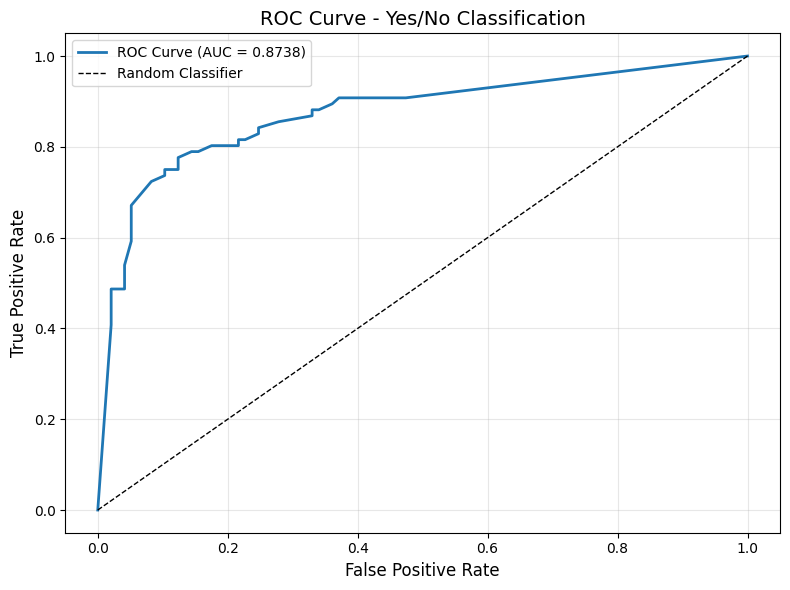

In [ ]:
# Compute AUC against ground truth
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Get ground truth labels
y_true = new_eval_dataset['answer'][:len(results)]  # Binary labels (0 or 1)

# Get predicted probabilities and logprobs for "yes" (positive class)
y_pred_probs = []
yes_logprobs = []
no_logprobs = []

for idx in sorted(results.keys()):
    yes_logprob = results[idx][0, 0].item()
    no_logprob = results[idx][0, 1].item()
    yes_prob = torch.exp(results[idx][0, 0]).item()
    
    y_pred_probs.append(yes_prob)
    yes_logprobs.append(yes_logprob)
    no_logprobs.append(no_logprob)

y_pred_probs = np.array(y_pred_probs)
yes_logprobs = np.array(yes_logprobs)
no_logprobs = np.array(no_logprobs)

# Compute AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC Score: {auc:.4f}")

# Get binary predictions (comparing logprobs is more stable than probability threshold)
y_pred_binary = (yes_logprobs > no_logprobs).astype(int)

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['no', 'yes']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_binary))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Yes/No Classification', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
